# Extracción y preprocesamiento de datos
## Extracción
### Librerías

In [2]:
from Bio import SeqIO
import os

In [3]:
codon_inicio = ['AUG']
codon_terminacion = ['UAA', 'UAG', 'UGA']

def transcribir_adn_a_arnm(seq):
    ARNm = seq.replace('T', 'U')
    ARNm = [ARNm[i:i+3] for i in range(0, len(ARNm), 3)]  # Separar en tripletes
    return ARNm

# Función para extraer secuencias de ARNm con codones de inicio y terminación
def extraccion(codon_inicio, codon_terminacion, ARNm):
    hay_inicio = any(codon in ARNm for codon in codon_inicio)
    hay_terminacion = any(codon in ARNm for codon in codon_terminacion)
    
    if hay_inicio and hay_terminacion:
        print("La secuencia de ARNm contiene el codón de inicio y algún codón de terminación.")
        return 1
    else:
        # Lanzar un error si no se encuentran los codones necesarios
        raise ValueError("La secuencia de ARNm no contiene el codón de inicio o el codón de terminación. Proceso detenido.")

# Directorio donde están los archivos FASTA
directorio = "raw"

# Procesar cada archivo FASTA en el directorio
for archivo_fasta in os.listdir(directorio):
    if archivo_fasta.endswith(".fasta"):
        ruta_archivo = os.path.join(directorio, archivo_fasta)
        
        for record in SeqIO.parse(ruta_archivo, "fasta"):
            propietario_gen = record.id
            
            secuencia_adn = str(record.seq)
            
            ARNm = transcribir_adn_a_arnm(secuencia_adn)
            print(f"Propietario del gen: {propietario_gen}")
            #print(f"ARNm en tripletes: {ARNm}")
            
            extraccion(codon_inicio, codon_terminacion, ARNm)

Propietario del gen: NM_001008784.4
La secuencia de ARNm contiene el codón de inicio y algún codón de terminación.
Propietario del gen: NM_001009615.3
La secuencia de ARNm contiene el codón de inicio y algún codón de terminación.
Propietario del gen: NM_001014445.2
La secuencia de ARNm contiene el codón de inicio y algún codón de terminación.
Propietario del gen: NM_001015049.5
La secuencia de ARNm contiene el codón de inicio y algún codón de terminación.
Propietario del gen: NM_001042490.6
La secuencia de ARNm contiene el codón de inicio y algún codón de terminación.
Propietario del gen: NM_001089591.2
La secuencia de ARNm contiene el codón de inicio y algún codón de terminación.
Propietario del gen: NM_001099270.4
La secuencia de ARNm contiene el codón de inicio y algún codón de terminación.
Propietario del gen: NM_001142546.4
La secuencia de ARNm contiene el codón de inicio y algún codón de terminación.
Propietario del gen: NM_001142640.2
La secuencia de ARNm contiene el codón de in

# Modelos de clasificación
### Librerías

In [3]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tabulate import tabulate

## Lectura de las secuencias de proteínas

In [5]:
def load_protein_sequences(folder_path):
    sequences = []
    for file in os.listdir(folder_path):
        if file.endswith(".fasta"): # or file.endswith(".fa"):
            for record in SeqIO.parse(os.path.join(folder_path, file), "fasta"):
                sequences.append(str(record.seq))
    return sequences

# Carga las secuencias de la carpeta 'proteins'
folder_path = "proteins"
protein_sequences = load_protein_sequences(folder_path)

## Aplicar One-Hot Encoding para las proteínas
Este tipo de codificación convierte cada secuencia en una representación binaria, donde cada aminoácido se representa como un vector en el que solo uno de los valores es 1 (el que corresponde a ese aminoácido), y el resto son 0.

Supongamos que tenemos la secuencia: "ACD". La función lo convierte en una representación One-Hot donde:

- 'A' → [1, 0, 0, ...] (un vector de 20 posiciones, donde la primera es 1),
- 'C' → [0, 1, 0, ...],
- 'D' → [0, 0, 1, ...].

In [8]:
def one_hot_encode(sequences):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # Aminoácidos estándar
    aa_to_index = {aa: idx for idx, aa in enumerate(amino_acids)}
    
    # Crear matriz de One-Hot Encoding: [ [[], [], []], [[], []], [[], [], []-->Aminoácido en binario (vector de 20 0s) ]--> Número de aminoácidos en una proteína]--> Número de proteínas
    one_hot_matrix = np.zeros((len(sequences), max(len(seq) for seq in sequences), len(amino_acids)), dtype=int)
    
    for i, seq in enumerate(sequences): # Recorre cada proteína en la secuencia
        for j, aa in enumerate(seq): # Recorre cada aminoácido de la proteína
            if aa in aa_to_index:
                one_hot_matrix[i, j, aa_to_index[aa]] = 1 # Es un 1 para representar cada aminoácido en binario
    
    return one_hot_matrix

one_hot_encoded = one_hot_encode(protein_sequences)


## Aplicar K-means para obtener las etiquetas

Etiquetas de k-means: [1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 2 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1]


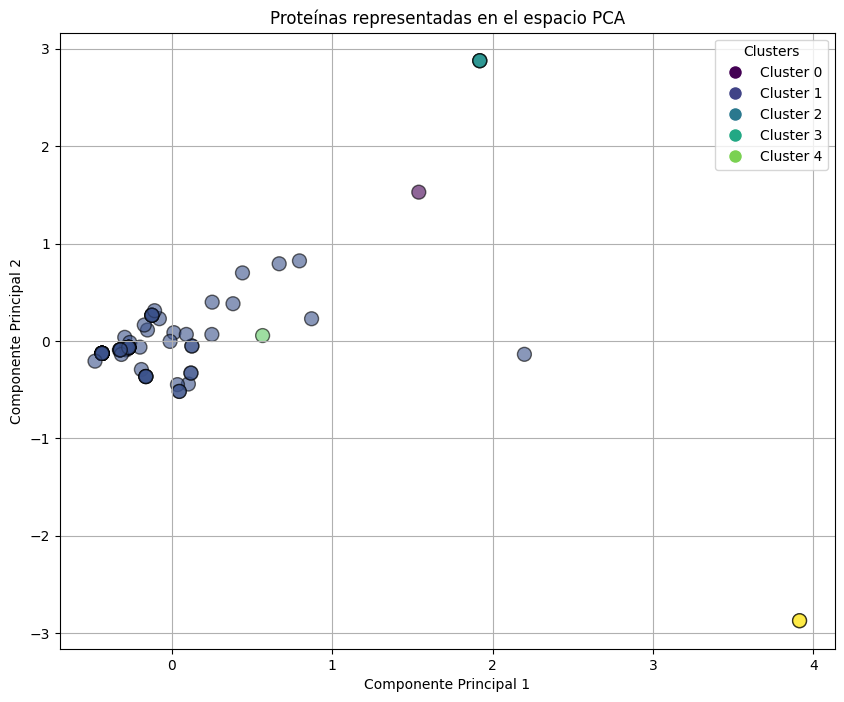

In [29]:
# Aplanar la matriz de One-Hot para aplicar k-means
n_samples, max_length, n_features = one_hot_encoded.shape 
X = one_hot_encoded.reshape(n_samples, max_length * n_features)

# Aplicar k-means: Cada secuencia se asigna a un cluster basado en su cercanía a los centroides generados por el algoritmo.
n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
labels = kmeans.fit_predict(X)

print("Etiquetas de k-means:", labels)

# Realizar PCA para reducir la dimensionalidad
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = labels

plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['Cluster'], cmap='viridis', alpha=0.6, edgecolor='k', s=100)
plt.title('Proteínas representadas en el espacio PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

legend_labels = [f'Cluster {i}' for i in range(n_clusters)]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i/n_clusters), markersize=10) for i in range(n_clusters)]
plt.legend(handles, legend_labels, title='Clusters', loc='upper right')

plt.grid()
plt.show()

In [23]:
protein_df = pd.DataFrame({
    'Protein_Sequence': protein_sequences,
    'Cluster_Label': labels
})

display(protein_df)

clustered_proteins = protein_df.groupby('Cluster_Label')['Protein_Sequence'].apply(list)
print("\nProteínas por clúster:")
display(pd.DataFrame(clustered_proteins))

,Protein_Sequence,Cluster_Label
0,MVFLCMRPVFLFL,1
1,MEQPTSSTNGEKRKSPC,1
2,MGAGGVAAGR,1
3,MQLGAQLRCRTP,1
4,M,1
...,...,...
95,MALSFSLL,1
96,MAGRARRRQRRQRGRRF,1
97,M,1
98,MAL,1



Proteínas por clúster:


,Protein_Sequence
Cluster_Label,
0,[MAGRSLCLTRSSVPGTPFPPPVQQPSTPGPDLLALEEEY]
1,"[MVFLCMRPVFLFL, MEQPTSSTNGEKRKSPC, MGAGGVAAGR,..."
2,"[MAAVAAPHLSATAPGAV, MAAVAAPHLSATAPGAV, MAAVAAP..."
3,[MEPGLEHALRRTPSWSSLGGS]
4,"[MVGLAPPFRGKPRAPGIARGSAPAPPDL, MVGLAPPFRGKPRAP..."


## Entrenamiento con los datos etiquetados

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Entrenar un modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

rf_report = classification_report(y_test, rf_predictions, zero_division=1, output_dict=True) # Calcula varias métricas de clasificación
rf_df = pd.DataFrame(rf_report).transpose()

print("Random Forest Classification Report:")
print(tabulate(rf_df, headers='keys', tablefmt='psql', floatfmt='.2f'))

# Entrenar un modelo SVM
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

svm_predictions = svm_model.predict(X_test)

svm_report = classification_report(y_test, svm_predictions, zero_division=1, output_dict=True)
svm_df = pd.DataFrame(svm_report).transpose()

print("\nSVM Classification Report:")
print(tabulate(svm_df, headers='keys', tablefmt='psql', floatfmt='.2f'))

Random Forest Classification Report:
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| 1            |        0.94 |     1.00 |       0.97 |     17.00 |
| 2            |        1.00 |     1.00 |       1.00 |      1.00 |
| 3            |        1.00 |     0.00 |       0.00 |      1.00 |
| 4            |        1.00 |     1.00 |       1.00 |      1.00 |
| accuracy     |        0.95 |     0.95 |       0.95 |      0.95 |
| macro avg    |        0.99 |     0.75 |       0.74 |     20.00 |
| weighted avg |        0.95 |     0.95 |       0.93 |     20.00 |
+--------------+-------------+----------+------------+-----------+

SVM Classification Report:
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+----------